In [1]:
import yfinance as yf
import numpy as np
#import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf
import pyspark.pandas as pd

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

C:\Users\Amruta\.conda\envs\mytensor_env\lib\site-packages\pyspark\pandas\__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [2]:
# Step 1: Fetch stock data using yfinance
stock_symbol = '^NSEI'
start_date = '2001-01-01'
end_date = '2024-07-09'
data = yf.download(stock_symbol, start = start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [3]:
data.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-09-17,4518.450195,4549.049805,4482.850098,4494.649902,4494.649902,0
2007-09-18,4494.100098,4551.799805,4481.549805,4546.200195,4546.200195,0
2007-09-19,4550.250000,4739.000000,4550.250000,4732.350098,4732.350098,0
2007-09-20,4734.850098,4760.850098,4721.149902,4747.549805,4747.549805,0
2007-09-21,4752.950195,4855.700195,4733.700195,4837.549805,4837.549805,0


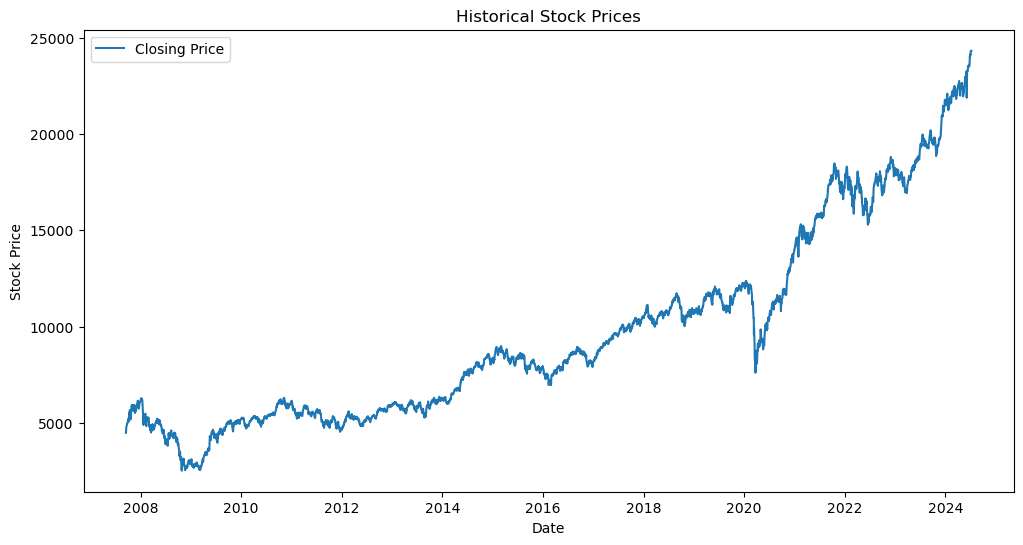

In [4]:
# visualize Historical Prices
plt.figure(figsize=(12,6))
plt.plot(data.index, data['Close'], label= 'Closing Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Historical Stock Prices')
plt.legend()
plt.show()

**Insights:**

+ The Nifty 50 index has shown a strong long-term uptrend from 2001 to 2024, indicating overall growth in the Indian stock market over this period.

+ A significant dip is noticeable around 2008, corresponding to the global financial crisis. This period saw a sharp decline in stock prices worldwide.

+ Following the 2008 crisis, there was a recovery and subsequent growth phase, with the index steadily rising until around 2020.

+ There is a noticeable dip around early 2020, reflecting the market's reaction to the COVID-19 pandemic. The sharp decline is followed by a rapid recovery, demonstrating resilience.

+ From 2021 onwards, the index shows a strong upward trajectory, reaching new highs by mid-2024. This suggests robust economic recovery and growth post-pandemic.

+ The latest part of the graph indicates that the index is at its highest point as of 2024, suggesting strong market confidence and potentially favorable economic conditions in India.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4118 entries, 2007-09-17 to 2024-07-08
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       4118 non-null   float64
 1   High       4118 non-null   float64
 2   Low        4118 non-null   float64
 3   Close      4118 non-null   float64
 4   Adj Close  4118 non-null   float64
 5   Volume     4118 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 225.2 KB


In [6]:
# checking Null Values
data.isnull().sum() #/
data.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [7]:
data.shape

(4118, 6)

## Adding more derived columns for better result

In [8]:
# Adding more derived column like Exponential Moving Averges (EMA)
data['EMA_5'] = data['Close'].rolling(window=5).mean() 
# (This creates a rolling window of size 5. A rolling window means that for each point in time,it will consider the current value and the previous 4 
# values (a total of 5 values).This calculates the mean (average) of the values within the rolling window. So, for each point in time, it will take the current value and the previous 4 values, then compute their average.)
data['EMA_10'] = data['Close'].rolling(window=10).mean() 
data['EMA_20'] = data['Close'].rolling(window=20).mean() 
data['EMA_50'] = data['Close'].rolling(window=50).mean() 
data['EMA_100'] = data['Close'].rolling(window=100).mean() 
data['EMA_200'] = data['Close'].rolling(window=200).mean() 

In [9]:
data.shape

(4118, 12)

In [10]:
#checking null values
data.isna().sum()

Open           0
High           0
Low            0
Close          0
Adj Close      0
Volume         0
EMA_5          4
EMA_10         9
EMA_20        19
EMA_50        49
EMA_100       99
EMA_200      199
dtype: int64

In [11]:
#drop the values with null values
data.dropna(inplace=True)

In [12]:
data.shape

(3919, 12)

In [13]:
data.head(5)

,Open,High,Low,Close,Adj Close,Volume,EMA_5,EMA_10,EMA_20,EMA_50,EMA_100,EMA_200
Date,,,,,,,,,,,,
2008-07-07,4002.000000,4114.500000,4002.000000,4030.000000,4030.000000,0,3992.370020,4089.865015,4292.729993,4696.748003,4806.760994,5210.716744
2008-07-08,4028.699951,4028.699951,3896.050049,3988.550049,3988.550049,0,4010.730029,4069.610010,4269.667505,4674.285000,4795.442993,5208.186245
2008-07-09,3990.899902,4169.399902,3990.899902,4157.100098,4157.100098,0,4023.480029,4060.055029,4251.342505,4655.634004,4788.443994,5206.240745
2008-07-10,4155.649902,4187.950195,4110.399902,4162.200195,4162.200195,0,4070.770068,4044.690039,4232.485010,4634.968008,4781.683496,5203.389995
2008-07-11,4166.000000,4215.500000,4014.449951,4049.000000,4049.000000,0,4077.370068,4035.925049,4209.080005,4612.630010,4772.878994,5199.897246


In [14]:
pip install seaborn matplotlib

Note: you may need to restart the kernel to use updated packages.


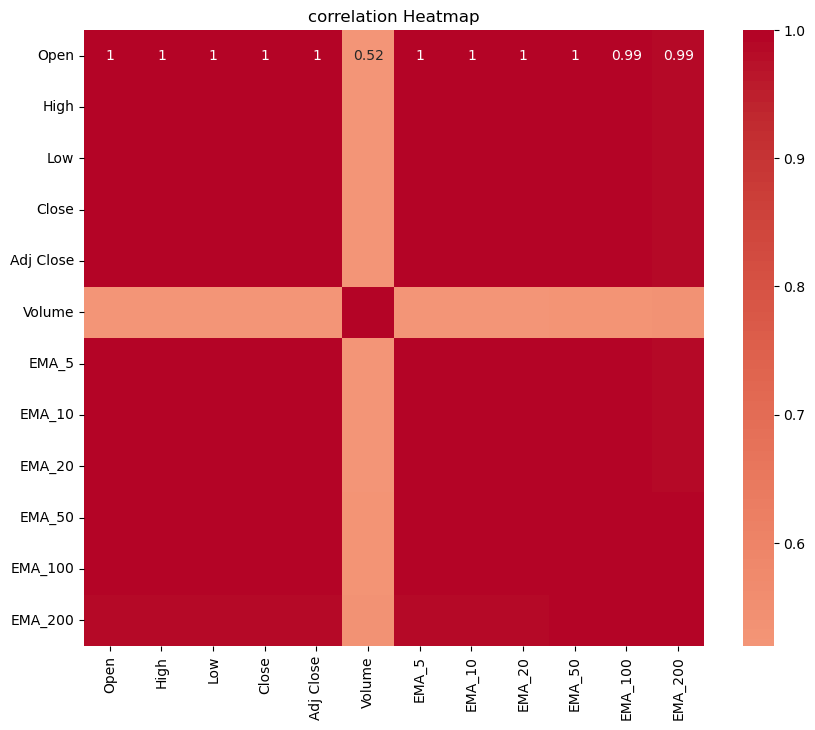

In [15]:
# Calculate Correlation Matrix
correlation_matrix = data.corr()

#display Correlation matrix as heatmap
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap = 'coolwarm', center =0)
plt.title('correlation Heatmap')
plt.grid(False)
plt.show()

**Insight:**

Above HeatMap Shows Columns of Whole Data are Highly Corelated Except Volume Column

In [16]:
X = data[['Open', 'High', 'Low', 'Close', 'Volume', 'EMA_5', 'EMA_10', 'EMA_20', 'EMA_50', 'EMA_100', 'EMA_200']]
y = data['Close']

In [17]:
X.head(5)

,Open,High,Low,Close,Volume,EMA_5,EMA_10,EMA_20,EMA_50,EMA_100,EMA_200
Date,,,,,,,,,,,
2008-07-07,4002.000000,4114.500000,4002.000000,4030.000000,0,3992.370020,4089.865015,4292.729993,4696.748003,4806.760994,5210.716744
2008-07-08,4028.699951,4028.699951,3896.050049,3988.550049,0,4010.730029,4069.610010,4269.667505,4674.285000,4795.442993,5208.186245
2008-07-09,3990.899902,4169.399902,3990.899902,4157.100098,0,4023.480029,4060.055029,4251.342505,4655.634004,4788.443994,5206.240745
2008-07-10,4155.649902,4187.950195,4110.399902,4162.200195,0,4070.770068,4044.690039,4232.485010,4634.968008,4781.683496,5203.389995
2008-07-11,4166.000000,4215.500000,4014.449951,4049.000000,0,4077.370068,4035.925049,4209.080005,4612.630010,4772.878994,5199.897246


In [18]:
y.head(5)

Date
2008-07-07    4030.000000
2008-07-08    3988.550049
2008-07-09    4157.100098
2008-07-10    4162.200195
2008-07-11    4049.000000
Name: Close, dtype: float64

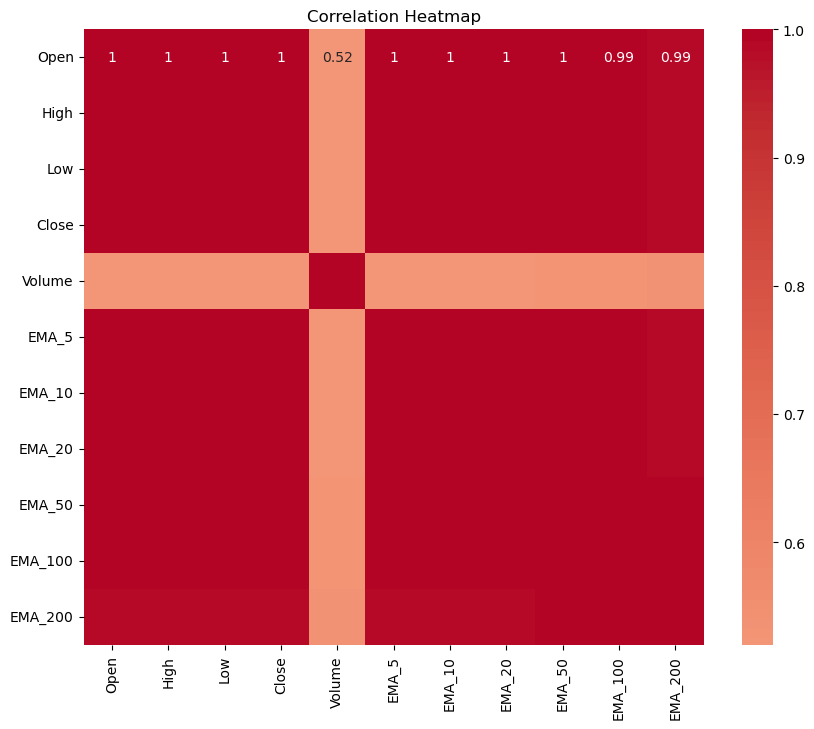

In [19]:
correlation_matrix = X.corr()

# Display correlation matrix as heatmap

plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap = 'coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.grid(False)
plt.show()

In [20]:
# Split the data into training and testing sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.20, random_state = 42)

In [21]:
# Create pipelines for diffrent regression models
pipelines = {
    'Linear Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
    ]),
    'Random Forest': Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', RandomForestRegressor())
    ]),
    'KNN': Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', KNeighborsRegressor())
    ]),
    'Elastic Net': Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', ElasticNet())
    ]),
}

pipelines

{'Linear Regression': Pipeline(steps=[('scaler', StandardScaler()),
                 ('regressor', LinearRegression())]),
 'Random Forest': Pipeline(steps=[('scaler', StandardScaler()),
                 ('regressor', RandomForestRegressor())]),
 'KNN': Pipeline(steps=[('scaler', StandardScaler()),
                 ('regressor', KNeighborsRegressor())]),
 'Elastic Net': Pipeline(steps=[('scaler', StandardScaler()), ('regressor', ElasticNet())])}

**Hyperparameter tuning is done for finding the best combination of hyperparameters to achieve optimal performance. GridSearchCV systematically explores different hyperparameter combinations using cross-validation to find the best ones.**

In [22]:
# Perform hyperparameter tuning for Elastic Net
# alpha controls the overall strength of regularization, and l1_ratio controls the mix of L1 and L2 regularization.
param_grid = {
    'regressor__alpha': np.logspace(-3, 3, 7),
    'regressor__l1_ratio': np.linspace(0, 1, 11),
}

# Create the GridSearchCV object
best_model = GridSearchCV(pipelines['Elastic Net'], param_grid, cv=5, scoring='r2')

# Fit the model
best_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('regressor', ElasticNet())]),
             param_grid={'regressor__alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'regressor__l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             scoring='r2')

In [23]:
# Print the best parameters and the best score
print("Best Parameters:", best_model.best_params_)
print("Best CV Score:", best_model.best_score_)

Best Parameters: {'regressor__alpha': 0.01, 'regressor__l1_ratio': 0.8}
Best CV Score: 0.9999244579787309


In [24]:
from sklearn.metrics import r2_score, mean_squared_error

r2_scores = {}
mse_scores = {}

for name, pipeline in pipelines.items(): 
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    r2_scores[name] = r2_score(y_test, y_pred)
    mse_scores[name] = mean_squared_error(y_test, y_pred)

#(for statement in the above code is used to iterate over each defined pipeline, fit the models to the training data, make predictions on the test data, 
#calculate evaluation metrics (R² scores and MSE). This allows you to evaluate the performance of each model in a systematic way.)

print("Evaluation Result:")

for name in pipelines.keys():
    print(f"{name}: R2_score = {r2_scores[name]:.4f}, MSE = {mse_scores[name]:.4f}")
    print("***************************************************************************")

Evaluation Result:
Linear Regression: R2_score = 1.0000, MSE = 0.0000
***************************************************************************
Random Forest: R2_score = 1.0000, MSE = 347.2333
***************************************************************************
KNN: R2_score = 0.9996, MSE = 10594.0263
***************************************************************************
Elastic Net: R2_score = 0.9961, MSE = 93850.2026
***************************************************************************


## Visualization and Comparision of models

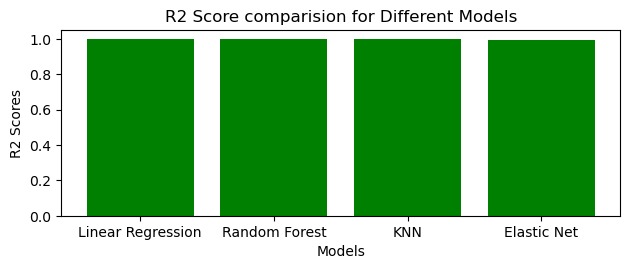

In [25]:
## Plot r2 score for all model for comaprision
plt.subplot(2,1,2)
plt.bar(r2_scores.keys(), r2_scores.values(), color = 'green')
plt.xlabel("Models")
plt.ylabel("R2 Scores")
plt.title("R2 Score comparision for Different Models")
plt.grid(False)
plt.tight_layout()
plt.show()

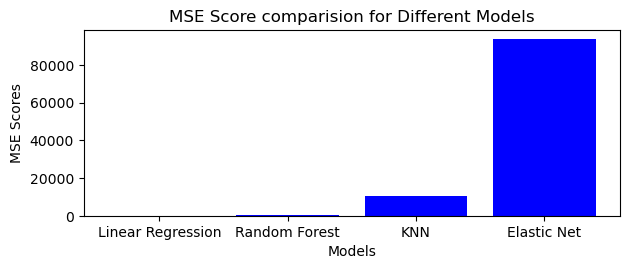

In [26]:
## Plot r2 score for all model for comaprision
plt.subplot(2,1,2)
#plt.bar(r2_scores.keys(), r2_scores.values(), color = 'green')
plt.bar(mse_scores.keys(), mse_scores.values(), color = 'b')
plt.xlabel("Models")
#plt.ylabel("R2 Scores")
plt.ylabel("MSE Scores")
plt.title("MSE Score comparision for Different Models")
plt.grid(False)
plt.tight_layout()
plt.show()

## LSTM model)

In [27]:
#This reshaping is necessary because LSTM models expect input in the shape of (samples, time steps, features)
X_train_lstm = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = np.reshape(X_test.values,(X_test.shape[0], X_test.shape[1], 1))


model = Sequential()
model.add(LSTM(units =50, return_sequences = True, input_shape = (X_train_lstm.shape[1], 1)))
model.add(LSTM(units =50, return_sequences = False))
model.add(Dense(units =25))
model.add(Dense(units =1))

#adam is an optimizer adam=adaptive momentum
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train_lstm, y_train, batch_size =20, epochs = 100)

Epoch 1/100
157/157 [==============================] - 15s 18ms/step - loss: 124410688.0000
Epoch 2/100
157/157 [==============================] - 3s 19ms/step - loss: 120426144.0000
Epoch 3/100
157/157 [==============================] - 3s 18ms/step - loss: 113856904.0000
Epoch 4/100
157/157 [==============================] - 3s 16ms/step - loss: 105102248.0000
Epoch 5/100
157/157 [==============================] - 2s 15ms/step - loss: 94836552.0000
Epoch 6/100
157/157 [==============================] - 2s 15ms/step - loss: 83818664.0000
Epoch 7/100
157/157 [==============================] - 2s 15ms/step - loss: 72768320.0000
Epoch 8/100
157/157 [==============================] - 2s 15ms/step - loss: 62299228.0000
Epoch 9/100
157/157 [==============================] - 2s 15ms/step - loss: 52913232.0000
Epoch 10/100
157/157 [==============================] - 2s 15ms/step - loss: 44971624.0000
Epoch 11/100
157/157 [==============================] - 2s 15ms/step - loss: 38657624.0000
Epo

In [29]:
# Evaluate the LSTM Model
y_pred_lstm = model.predict(X_test_lstm)
r2_lstm = r2_score(y_test,y_pred_lstm)
MSE_lstm = mean_squared_error(y_test, y_pred_lstm)
print(f"LSTM R2 Score : {r2_lstm :.4f}")
print(f"LSTM Mean Squared Error : {MSE_lstm:.4f}")

25/25 [==============================] - 0s 9ms/step
LSTM R2 Score : 0.4016
LSTM Mean Squared Error : 14414153.9438


## Choose a specific day for prediction

In [49]:
specific_day = '2023-11-01'  #Adjust this date based on available data
specific_day_data = data.loc[specific_day]

In [50]:
#  Predict the closing price for the specific day using each model

predicted_prices = {}
for name,pipeline in pipelines.items():
    predicted_price = pipeline.predict([specific_day_data[['Open', 'High', 'Low', 'Close', 'Volume', 'EMA_5', 'EMA_10', 'EMA_20', 'EMA_50', 'EMA_100', 'EMA_200']]])
    predicted_prices[name] = predicted_price[0]

lstm_input = np.reshape(specific_day_data[['Open', 'High', 'Low', 'Close', 'Volume', 'EMA_5', 'EMA_10', 'EMA_20', 'EMA_50', 'EMA_100', 'EMA_200']].values, (1,X.shape[1],1))
lstm_predicted_price = model.predict(lstm_input)[0][0]
predicted_prices['LSTM'] = lstm_predicted_price

actual_price = specific_day_data['Close']

1/1 [==============================] - 0s 64ms/step


In [57]:
# Print predicted and actual prices for the specific day
print(f"Actual price on {specific_day}: {actual_price:.2f}")

print("predicted_prices:")
for name, price in predicted_prices.items():
    print(f"{name}: {price:.2f}")

Actual price on 2023-11-01: 18989.15
predicted_prices:
Linear Regression: 18989.15
Random Forest: 19026.73
KNN: 19162.92
Elastic Net: 18850.89
LSTM: 11857.49


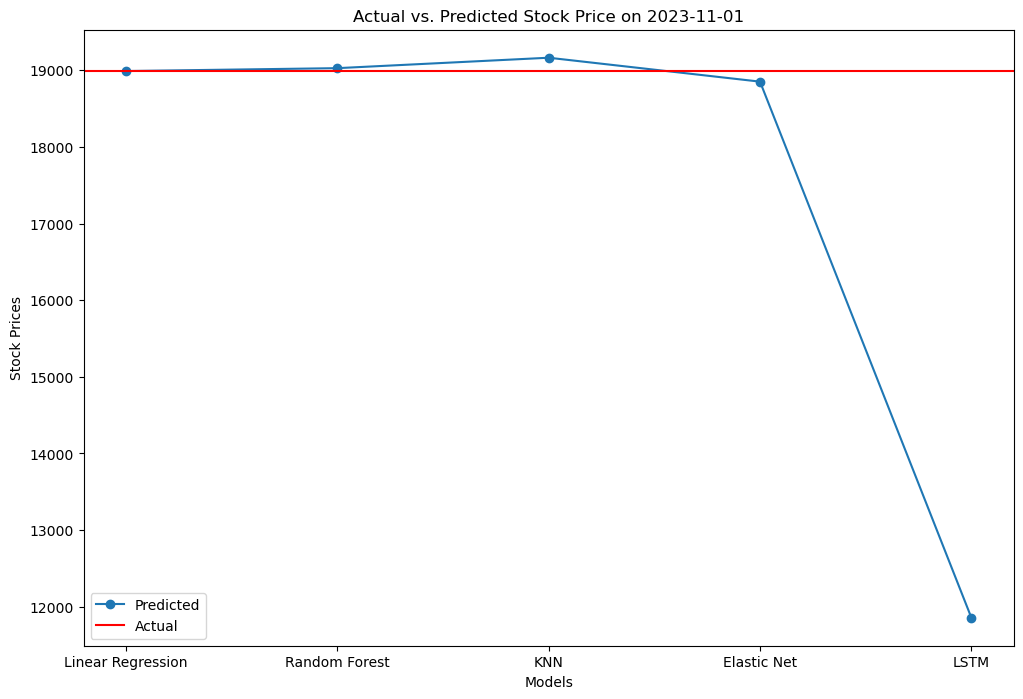

In [62]:
# Plot actual vs. predicted values for the specific day
plt.figure(figsize=(12, 8))

# Plot predicted prices
plt.plot(predicted_prices.keys(), predicted_prices.values(), marker='o', label='Predicted')

# Plot the actual price as a horizontal line
plt.axhline(y=actual_price, label='Actual', linestyle='-', color='r')

# Add labels and title
plt.xlabel("Models")
plt.ylabel("Stock Prices")
plt.title(f"Actual vs. Predicted Stock Price on {specific_day}")
plt.legend()

# Show the plot
plt.show()

## Analysis:

**Linear Regression, Random Forest, and KNN:** 
These models have predicted prices close to the actual price, showing good prediction accuracy.

**Elastic Net:**
This model's prediction is slightly lower than the actual price but still relatively close.

**LSTM:**
The LSTM model's prediction is significantly lower than the actual price, indicating a poor prediction for this specific day.

## Conclusion:

**Best Performing Models:**
Linear Regression, Random Forest, and KNN models perform well as their predictions are close to the actual price.

**Poor Performing Model:**
LSTM model's prediction is far from the actual price, suggesting it might not be the best model for this dataset or requires further tuning.

## Next Steps:
+ Investigate why the LSTM model is underperforming and consider additional tuning or different preprocessing steps.
+ Depending on the application, the best-performing models (Linear Regression, Random Forest, and KNN) can be further analyzed or combined for better predictions.

## Choose a specific day for prediction

In [72]:
future_date = "2024-08-25"  # Choose a future date beyond the available dataset
future_data = data.iloc[-1:].copy()  # Use the last available data point as a template
future_data.index = pd.to_datetime([future_date])  # Set the index to the chosen future date

#  Predict the closing price for the future date using each model
predicted_prices ={}
for name, pipeline in pipelines.items():
    model_X = pipeline.named_steps['scaler'].transform(future_data[['Open', 'High', 'Low', 'Close', 'Volume', 'EMA_5', 'EMA_10', 'EMA_20', 'EMA_50', 'EMA_100', 'EMA_200']])
    future_prediction = pipeline.named_steps['regressor'].predict(model_X)
    predicted_prices[name] = future_prediction[0]

# LSTM model
lstm_input = np.reshape(future_data[['Open', 'High', 'Low', 'Close', 'Volume', 'EMA_5', 'EMA_10', 'EMA_20', 'EMA_50', 'EMA_100', 'EMA_200']].values, (1, X.shape[1], 1))
lstm_future_prediction = model.predict(lstm_input)[0][0]
predicted_prices['LSTM'] = lstm_future_prediction

#  Print predicted prices for the future date
print(f"Predicted prices for {future_date}: ")
for name, price in predicted_prices.items():
    print(f"{name} : {price:.2f}")

1/1 [==============================] - 0s 39ms/step
Predicted prices for 2024-08-25: 
Linear Regression : 24320.55
Random Forest : 24312.02
KNN : 24008.46
Elastic Net : 23231.34
LSTM : 11857.49
